### Load Dependencies

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from ecg_dataset import ECGDataset

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


### Load Dataset

In [2]:
dataset = ECGDataset("../data/preprocessed_beats.npy")
train_loader = DataLoader(dataset, batch_size=512, shuffle=True)

### Define Generative Adverserial Network Architecture

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_len=360):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, out_len),
            nn.LeakyReLU()
        )

    def forward(self, z):
        return self.model(z).unsqueeze(1)  # [B, 1, 360]

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_len=360):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=2, padding=2),  # [B, 16, 180]
            nn.LeakyReLU(0.2),
            nn.Conv1d(16, 32, 5, stride=2, padding=2), # [B, 32, 90]
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(32 * 90, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Training Loop

In [5]:
gen = Generator().to(device)
disc = Discriminator().to(device)

loss_fn = nn.BCELoss()
opt_gen = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

noise_dim = 100
n_epochs = 100

for epoch in tqdm(range(n_epochs)):
    for real_batch in train_loader:
        real_batch = real_batch.to(device)  # [B, 1, 360]
        B = real_batch.size(0)

        # Train Discriminator
        noise = torch.randn(B, noise_dim).to(device)
        fake_batch = gen(noise)

        real_labels = torch.ones(B, 1).to(device)
        fake_labels = torch.zeros(B, 1).to(device)

        # Real loss
        out_real = disc(real_batch)
        loss_real = loss_fn(out_real, real_labels)

        # Fake loss
        out_fake = disc(fake_batch.detach())
        loss_fake = loss_fn(out_fake, fake_labels)

        loss_disc = (loss_real + loss_fake) / 2

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator
        noise = torch.randn(B, noise_dim).to(device)
        fake_batch = gen(noise)
        out_fake = disc(fake_batch)
        loss_gen = loss_fn(out_fake, real_labels)

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch {epoch+1}/{n_epochs} | Disc. Loss: {loss_disc.item():.4f} | Genr. Loss: {loss_gen.item():.4f}")

  1%|          | 1/100 [00:02<03:49,  2.32s/it]

Epoch 1/100 | Disc. Loss: 0.5143 | Genr. Loss: 1.1639


  2%|▏         | 2/100 [00:03<03:02,  1.87s/it]

Epoch 2/100 | Disc. Loss: 0.4271 | Genr. Loss: 1.2188


  3%|▎         | 3/100 [00:05<02:48,  1.73s/it]

Epoch 3/100 | Disc. Loss: 0.4458 | Genr. Loss: 1.1876


  4%|▍         | 4/100 [00:07<02:39,  1.66s/it]

Epoch 4/100 | Disc. Loss: 0.3646 | Genr. Loss: 1.3477


  5%|▌         | 5/100 [00:08<02:36,  1.64s/it]

Epoch 5/100 | Disc. Loss: 0.2824 | Genr. Loss: 1.5799


  6%|▌         | 6/100 [00:10<02:28,  1.58s/it]

Epoch 6/100 | Disc. Loss: 0.2371 | Genr. Loss: 1.6871


  7%|▋         | 7/100 [00:11<02:21,  1.52s/it]

Epoch 7/100 | Disc. Loss: 0.5158 | Genr. Loss: 1.2263


  8%|▊         | 8/100 [00:12<02:17,  1.49s/it]

Epoch 8/100 | Disc. Loss: 0.3356 | Genr. Loss: 1.4754


  9%|▉         | 9/100 [00:14<02:13,  1.47s/it]

Epoch 9/100 | Disc. Loss: 0.1566 | Genr. Loss: 2.5555


 10%|█         | 10/100 [00:15<02:10,  1.45s/it]

Epoch 10/100 | Disc. Loss: 0.4363 | Genr. Loss: 1.2600


 11%|█         | 11/100 [00:17<02:08,  1.44s/it]

Epoch 11/100 | Disc. Loss: 0.3591 | Genr. Loss: 1.3696


 12%|█▏        | 12/100 [00:18<02:06,  1.43s/it]

Epoch 12/100 | Disc. Loss: 0.3026 | Genr. Loss: 1.5720


 13%|█▎        | 13/100 [00:19<02:03,  1.42s/it]

Epoch 13/100 | Disc. Loss: 0.2457 | Genr. Loss: 1.7102


 14%|█▍        | 14/100 [00:21<02:01,  1.42s/it]

Epoch 14/100 | Disc. Loss: 0.3519 | Genr. Loss: 1.3914


 15%|█▌        | 15/100 [00:22<02:00,  1.42s/it]

Epoch 15/100 | Disc. Loss: 0.2052 | Genr. Loss: 1.8429


 16%|█▌        | 16/100 [00:24<01:58,  1.42s/it]

Epoch 16/100 | Disc. Loss: 0.2099 | Genr. Loss: 2.0322


 17%|█▋        | 17/100 [00:25<01:57,  1.42s/it]

Epoch 17/100 | Disc. Loss: 0.2297 | Genr. Loss: 1.5869


 18%|█▊        | 18/100 [00:27<01:56,  1.42s/it]

Epoch 18/100 | Disc. Loss: 0.2998 | Genr. Loss: 1.4383


 19%|█▉        | 19/100 [00:28<01:54,  1.41s/it]

Epoch 19/100 | Disc. Loss: 0.2538 | Genr. Loss: 2.1257


 20%|██        | 20/100 [00:29<01:52,  1.41s/it]

Epoch 20/100 | Disc. Loss: 0.4716 | Genr. Loss: 1.6186


 21%|██        | 21/100 [00:31<01:51,  1.41s/it]

Epoch 21/100 | Disc. Loss: 0.2507 | Genr. Loss: 1.9205


 22%|██▏       | 22/100 [00:32<01:49,  1.41s/it]

Epoch 22/100 | Disc. Loss: 0.2683 | Genr. Loss: 1.7548


 23%|██▎       | 23/100 [00:34<01:48,  1.41s/it]

Epoch 23/100 | Disc. Loss: 0.2836 | Genr. Loss: 1.8035


 24%|██▍       | 24/100 [00:35<01:47,  1.41s/it]

Epoch 24/100 | Disc. Loss: 0.3086 | Genr. Loss: 1.4994


 25%|██▌       | 25/100 [00:36<01:45,  1.41s/it]

Epoch 25/100 | Disc. Loss: 0.3456 | Genr. Loss: 1.5357


 26%|██▌       | 26/100 [00:38<01:44,  1.41s/it]

Epoch 26/100 | Disc. Loss: 0.2981 | Genr. Loss: 1.6952


 27%|██▋       | 27/100 [00:39<01:43,  1.42s/it]

Epoch 27/100 | Disc. Loss: 0.2287 | Genr. Loss: 1.7595


 28%|██▊       | 28/100 [00:41<01:45,  1.46s/it]

Epoch 28/100 | Disc. Loss: 0.2383 | Genr. Loss: 2.0976


 29%|██▉       | 29/100 [01:04<09:37,  8.14s/it]

Epoch 29/100 | Disc. Loss: 0.2395 | Genr. Loss: 1.9639


 30%|███       | 30/100 [02:22<33:56, 29.09s/it]

Epoch 30/100 | Disc. Loss: 0.2060 | Genr. Loss: 2.1274


 31%|███       | 31/100 [02:24<23:57, 20.84s/it]

Epoch 31/100 | Disc. Loss: 0.2564 | Genr. Loss: 1.8705


 32%|███▏      | 32/100 [02:26<17:01, 15.02s/it]

Epoch 32/100 | Disc. Loss: 0.2704 | Genr. Loss: 2.1370


 33%|███▎      | 33/100 [02:27<12:13, 10.94s/it]

Epoch 33/100 | Disc. Loss: 0.3931 | Genr. Loss: 1.3060


 34%|███▍      | 34/100 [02:28<08:53,  8.09s/it]

Epoch 34/100 | Disc. Loss: 0.1512 | Genr. Loss: 2.2537


 35%|███▌      | 35/100 [02:30<06:36,  6.10s/it]

Epoch 35/100 | Disc. Loss: 0.2235 | Genr. Loss: 2.0699


 36%|███▌      | 36/100 [02:31<05:00,  4.69s/it]

Epoch 36/100 | Disc. Loss: 0.2446 | Genr. Loss: 2.0372


 37%|███▋      | 37/100 [02:33<03:54,  3.72s/it]

Epoch 37/100 | Disc. Loss: 0.2438 | Genr. Loss: 1.7183


 38%|███▊      | 38/100 [02:34<03:08,  3.04s/it]

Epoch 38/100 | Disc. Loss: 0.3283 | Genr. Loss: 1.5024


 39%|███▉      | 39/100 [02:36<02:35,  2.55s/it]

Epoch 39/100 | Disc. Loss: 0.2288 | Genr. Loss: 1.7949


 40%|████      | 40/100 [02:37<02:12,  2.21s/it]

Epoch 40/100 | Disc. Loss: 0.1342 | Genr. Loss: 2.4624


 41%|████      | 41/100 [02:38<01:56,  1.98s/it]

Epoch 41/100 | Disc. Loss: 0.2148 | Genr. Loss: 1.8249


 42%|████▏     | 42/100 [02:40<01:44,  1.81s/it]

Epoch 42/100 | Disc. Loss: 0.2799 | Genr. Loss: 1.6143


 43%|████▎     | 43/100 [02:41<01:35,  1.68s/it]

Epoch 43/100 | Disc. Loss: 0.5580 | Genr. Loss: 1.3294


 44%|████▍     | 44/100 [02:43<01:30,  1.61s/it]

Epoch 44/100 | Disc. Loss: 0.4839 | Genr. Loss: 1.4123


 45%|████▌     | 45/100 [02:44<01:25,  1.56s/it]

Epoch 45/100 | Disc. Loss: 0.4928 | Genr. Loss: 1.3201


 46%|████▌     | 46/100 [02:45<01:21,  1.51s/it]

Epoch 46/100 | Disc. Loss: 0.3048 | Genr. Loss: 1.8388


 47%|████▋     | 47/100 [02:47<01:18,  1.49s/it]

Epoch 47/100 | Disc. Loss: 0.4212 | Genr. Loss: 1.4541


 48%|████▊     | 48/100 [02:48<01:17,  1.50s/it]

Epoch 48/100 | Disc. Loss: 0.5036 | Genr. Loss: 1.3027


 49%|████▉     | 49/100 [02:50<01:15,  1.48s/it]

Epoch 49/100 | Disc. Loss: 0.3415 | Genr. Loss: 1.4797


 50%|█████     | 50/100 [02:51<01:13,  1.47s/it]

Epoch 50/100 | Disc. Loss: 0.3789 | Genr. Loss: 1.5198


 51%|█████     | 51/100 [02:53<01:11,  1.45s/it]

Epoch 51/100 | Disc. Loss: 0.4426 | Genr. Loss: 1.2117


 52%|█████▏    | 52/100 [02:54<01:09,  1.45s/it]

Epoch 52/100 | Disc. Loss: 0.2769 | Genr. Loss: 1.5642


 53%|█████▎    | 53/100 [02:56<01:07,  1.45s/it]

Epoch 53/100 | Disc. Loss: 0.4570 | Genr. Loss: 1.1177


 54%|█████▍    | 54/100 [02:57<01:06,  1.44s/it]

Epoch 54/100 | Disc. Loss: 0.3775 | Genr. Loss: 1.3096


 55%|█████▌    | 55/100 [02:58<01:04,  1.43s/it]

Epoch 55/100 | Disc. Loss: 0.3803 | Genr. Loss: 1.4770


 56%|█████▌    | 56/100 [03:00<01:03,  1.44s/it]

Epoch 56/100 | Disc. Loss: 0.5021 | Genr. Loss: 1.1046


 57%|█████▋    | 57/100 [03:01<01:01,  1.43s/it]

Epoch 57/100 | Disc. Loss: 0.3641 | Genr. Loss: 1.5180


 58%|█████▊    | 58/100 [03:03<00:59,  1.42s/it]

Epoch 58/100 | Disc. Loss: 0.4810 | Genr. Loss: 1.3855


 59%|█████▉    | 59/100 [03:04<00:58,  1.43s/it]

Epoch 59/100 | Disc. Loss: 0.3517 | Genr. Loss: 1.4513


 60%|██████    | 60/100 [03:06<00:56,  1.42s/it]

Epoch 60/100 | Disc. Loss: 0.4457 | Genr. Loss: 1.2181


 61%|██████    | 61/100 [03:07<00:55,  1.42s/it]

Epoch 61/100 | Disc. Loss: 0.3858 | Genr. Loss: 1.3319


 62%|██████▏   | 62/100 [03:08<00:53,  1.42s/it]

Epoch 62/100 | Disc. Loss: 0.3087 | Genr. Loss: 1.5667


 63%|██████▎   | 63/100 [03:10<00:52,  1.41s/it]

Epoch 63/100 | Disc. Loss: 0.3853 | Genr. Loss: 1.4446


 64%|██████▍   | 64/100 [03:11<00:50,  1.41s/it]

Epoch 64/100 | Disc. Loss: 0.3528 | Genr. Loss: 1.6824


 65%|██████▌   | 65/100 [03:13<00:49,  1.43s/it]

Epoch 65/100 | Disc. Loss: 0.4277 | Genr. Loss: 1.4141


 66%|██████▌   | 66/100 [03:14<00:48,  1.42s/it]

Epoch 66/100 | Disc. Loss: 0.4038 | Genr. Loss: 1.2851


 67%|██████▋   | 67/100 [03:15<00:47,  1.42s/it]

Epoch 67/100 | Disc. Loss: 0.3763 | Genr. Loss: 1.2909


 68%|██████▊   | 68/100 [03:17<00:45,  1.43s/it]

Epoch 68/100 | Disc. Loss: 0.4025 | Genr. Loss: 1.1193


 69%|██████▉   | 69/100 [03:18<00:44,  1.42s/it]

Epoch 69/100 | Disc. Loss: 0.3428 | Genr. Loss: 1.4915


 70%|███████   | 70/100 [03:20<00:42,  1.42s/it]

Epoch 70/100 | Disc. Loss: 0.3592 | Genr. Loss: 1.4972


 71%|███████   | 71/100 [03:21<00:41,  1.45s/it]

Epoch 71/100 | Disc. Loss: 0.3865 | Genr. Loss: 1.5796


 72%|███████▏  | 72/100 [03:23<00:40,  1.44s/it]

Epoch 72/100 | Disc. Loss: 0.4224 | Genr. Loss: 1.4613


 73%|███████▎  | 73/100 [03:24<00:38,  1.43s/it]

Epoch 73/100 | Disc. Loss: 0.4633 | Genr. Loss: 0.9527


 74%|███████▍  | 74/100 [03:26<00:37,  1.44s/it]

Epoch 74/100 | Disc. Loss: 0.3681 | Genr. Loss: 1.6206


 75%|███████▌  | 75/100 [03:27<00:35,  1.43s/it]

Epoch 75/100 | Disc. Loss: 0.4443 | Genr. Loss: 1.2393


 76%|███████▌  | 76/100 [03:29<00:35,  1.48s/it]

Epoch 76/100 | Disc. Loss: 0.3457 | Genr. Loss: 1.6882


 77%|███████▋  | 77/100 [03:30<00:34,  1.51s/it]

Epoch 77/100 | Disc. Loss: 0.4608 | Genr. Loss: 1.0580


 78%|███████▊  | 78/100 [03:32<00:33,  1.54s/it]

Epoch 78/100 | Disc. Loss: 0.4519 | Genr. Loss: 1.2011


 79%|███████▉  | 79/100 [03:33<00:31,  1.51s/it]

Epoch 79/100 | Disc. Loss: 0.3604 | Genr. Loss: 1.4776


 80%|████████  | 80/100 [03:35<00:30,  1.51s/it]

Epoch 80/100 | Disc. Loss: 0.3664 | Genr. Loss: 1.4460


 81%|████████  | 81/100 [03:36<00:28,  1.50s/it]

Epoch 81/100 | Disc. Loss: 0.3401 | Genr. Loss: 1.4745


 82%|████████▏ | 82/100 [03:38<00:26,  1.49s/it]

Epoch 82/100 | Disc. Loss: 0.4363 | Genr. Loss: 1.2645


 83%|████████▎ | 83/100 [03:39<00:25,  1.49s/it]

Epoch 83/100 | Disc. Loss: 0.4861 | Genr. Loss: 0.7140


 84%|████████▍ | 84/100 [03:41<00:23,  1.49s/it]

Epoch 84/100 | Disc. Loss: 0.3934 | Genr. Loss: 1.0936


 85%|████████▌ | 85/100 [03:42<00:22,  1.49s/it]

Epoch 85/100 | Disc. Loss: 0.3403 | Genr. Loss: 1.3349


 86%|████████▌ | 86/100 [03:44<00:20,  1.48s/it]

Epoch 86/100 | Disc. Loss: 0.3350 | Genr. Loss: 1.7937


 87%|████████▋ | 87/100 [03:45<00:19,  1.48s/it]

Epoch 87/100 | Disc. Loss: 0.3666 | Genr. Loss: 1.4861


 88%|████████▊ | 88/100 [03:47<00:17,  1.48s/it]

Epoch 88/100 | Disc. Loss: 0.3724 | Genr. Loss: 1.5230


 89%|████████▉ | 89/100 [03:48<00:16,  1.47s/it]

Epoch 89/100 | Disc. Loss: 0.3325 | Genr. Loss: 1.8062


 90%|█████████ | 90/100 [03:49<00:14,  1.48s/it]

Epoch 90/100 | Disc. Loss: 0.4542 | Genr. Loss: 1.0903


 91%|█████████ | 91/100 [03:51<00:13,  1.47s/it]

Epoch 91/100 | Disc. Loss: 0.3800 | Genr. Loss: 1.5045


 92%|█████████▏| 92/100 [03:52<00:11,  1.47s/it]

Epoch 92/100 | Disc. Loss: 0.3365 | Genr. Loss: 1.4751


 93%|█████████▎| 93/100 [03:54<00:10,  1.47s/it]

Epoch 93/100 | Disc. Loss: 0.3876 | Genr. Loss: 1.3401


 94%|█████████▍| 94/100 [03:55<00:08,  1.47s/it]

Epoch 94/100 | Disc. Loss: 0.3695 | Genr. Loss: 1.5779


 95%|█████████▌| 95/100 [03:57<00:07,  1.51s/it]

Epoch 95/100 | Disc. Loss: 0.4188 | Genr. Loss: 1.2833


 96%|█████████▌| 96/100 [03:58<00:06,  1.51s/it]

Epoch 96/100 | Disc. Loss: 0.4156 | Genr. Loss: 1.3645


 97%|█████████▋| 97/100 [04:00<00:04,  1.49s/it]

Epoch 97/100 | Disc. Loss: 0.4520 | Genr. Loss: 0.8170


 98%|█████████▊| 98/100 [04:01<00:02,  1.48s/it]

Epoch 98/100 | Disc. Loss: 0.3974 | Genr. Loss: 1.4998


 99%|█████████▉| 99/100 [04:03<00:01,  1.49s/it]

Epoch 99/100 | Disc. Loss: 0.2963 | Genr. Loss: 1.9924


100%|██████████| 100/100 [04:04<00:00,  2.45s/it]

Epoch 100/100 | Disc. Loss: 0.3917 | Genr. Loss: 1.3161


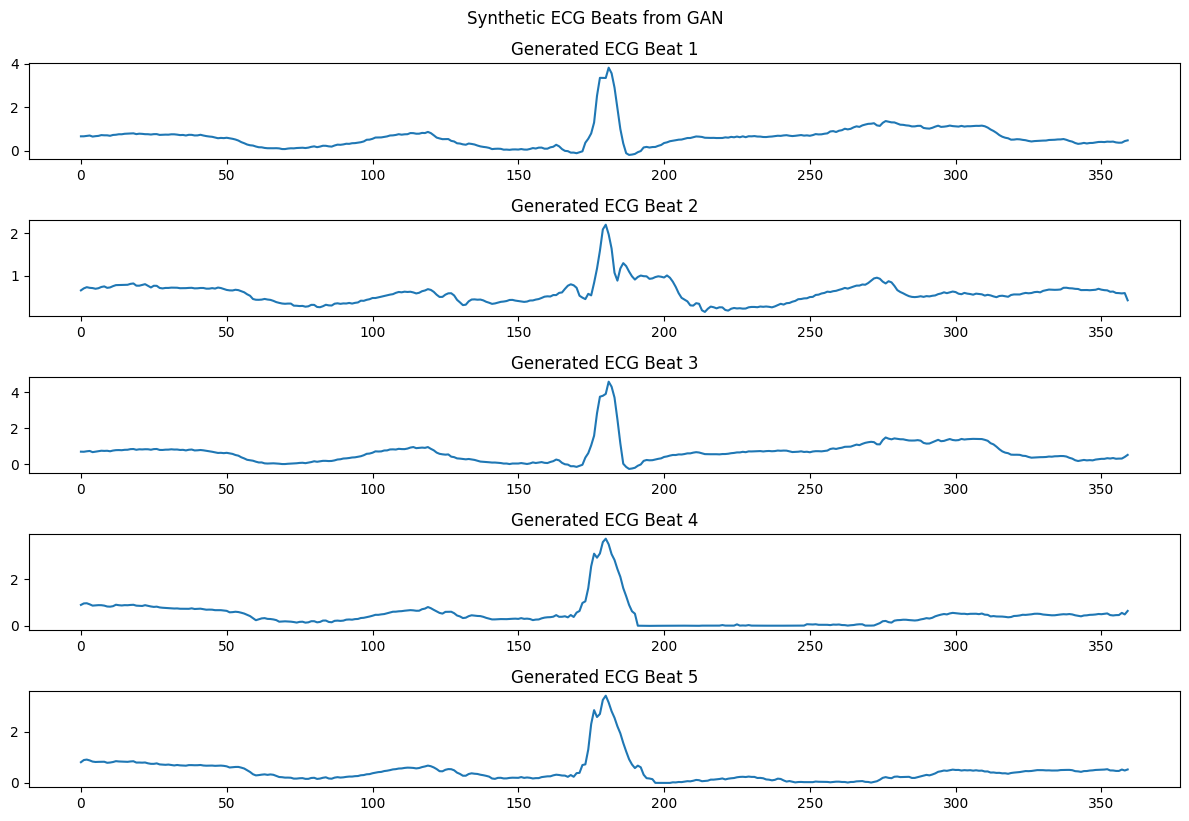

In [6]:
gen.eval()
with torch.no_grad():
    noise = torch.randn(5, noise_dim).to(device)
    samples = gen(noise).cpu().numpy()

plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(samples[i, 0])
    plt.title(f"Generated ECG Beat {i+1}")
plt.tight_layout()
plt.suptitle("Synthetic ECG Beats from GAN", y=1.02)
plt.show()